In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter
from pdb import set_trace
import numpy as np
import cv2
import torch.optim.lr_scheduler as Scheduler
from torch.autograd import Variable
from torch import autograd
import matplotlib.pyplot as plt
from PIL import Image
from pdb import set_trace
from PIL import ImageFile
import torchvision.models as models
from scipy.linalg import sqrtm
import torch.nn.functional as F


In [14]:
import os
from tqdm import tqdm

In [15]:
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')

class InceptionV3(nn.Module):
    """Pretrained InceptionV3 network returning feature maps"""

    # Index of default block of inception to return,
    # corresponds to output of final average pooling
    DEFAULT_BLOCK_INDEX = 3

    # Maps feature dimensionality to their output blocks indices
    BLOCK_INDEX_BY_DIM = {
        64: 0,   # First max pooling features
        192: 1,  # Second max pooling featurs
        768: 2,  # Pre-aux classifier features
        2048: 3  # Final average pooling features
    }

    def __init__(self,
                 output_blocks=[DEFAULT_BLOCK_INDEX],
                 resize_input=True,
                 normalize_input=True,
                 requires_grad=False):
        
        super(InceptionV3, self).__init__()

        self.resize_input = resize_input
        self.normalize_input = normalize_input
        self.output_blocks = sorted(output_blocks)
        self.last_needed_block = max(output_blocks)

        assert self.last_needed_block <= 3, \
            'Last possible output block index is 3'

        self.blocks = nn.ModuleList()

        
        inception = models.inception_v3(pretrained=True)

        # Block 0: input to maxpool1
        block0 = [
            inception.Conv2d_1a_3x3,
            inception.Conv2d_2a_3x3,
            inception.Conv2d_2b_3x3,
            nn.MaxPool2d(kernel_size=3, stride=2)
        ]
        self.blocks.append(nn.Sequential(*block0))

        # Block 1: maxpool1 to maxpool2
        if self.last_needed_block >= 1:
            block1 = [
                inception.Conv2d_3b_1x1,
                inception.Conv2d_4a_3x3,
                nn.MaxPool2d(kernel_size=3, stride=2)
            ]
            self.blocks.append(nn.Sequential(*block1))

        # Block 2: maxpool2 to aux classifier
        if self.last_needed_block >= 2:
            block2 = [
                inception.Mixed_5b,
                inception.Mixed_5c,
                inception.Mixed_5d,
                inception.Mixed_6a,
                inception.Mixed_6b,
                inception.Mixed_6c,
                inception.Mixed_6d,
                inception.Mixed_6e,
            ]
            self.blocks.append(nn.Sequential(*block2))

        # Block 3: aux classifier to final avgpool
        if self.last_needed_block >= 3:
            block3 = [
                inception.Mixed_7a,
                inception.Mixed_7b,
                inception.Mixed_7c,
                nn.AdaptiveAvgPool2d(output_size=(1, 1))
            ]
            self.blocks.append(nn.Sequential(*block3))

        for param in self.parameters():
            param.requires_grad = requires_grad

    def forward(self, inp):
        """Get Inception feature maps
        Parameters
        ----------
        inp : torch.autograd.Variable
            Input tensor of shape Bx3xHxW. Values are expected to be in
            range (0, 1)
        Returns
        -------
        List of torch.autograd.Variable, corresponding to the selected output
        block, sorted ascending by index
        """
        outp = []
        x = inp

        if self.resize_input:
            x = F.interpolate(x,
                              size=(299, 299),
                              mode='bilinear',
                              align_corners=False)

        if self.normalize_input:
            x = 2 * x - 1  # Scale from range (0, 1) to range (-1, 1)

        for idx, block in enumerate(self.blocks):
            x = block(x)
            if idx in self.output_blocks:
                outp.append(x)

            if idx == self.last_needed_block:
                break

        return outp
    
block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[2048]
model_inception = InceptionV3([block_idx])
model_inception = model_inception.to(device)

In [16]:
def calculate_activation_statistics(images,model,batch_size=128, dims=2048, cuda=False):
    model.eval()
    
    with torch.no_grad():
        act=np.empty((len(images), dims))

        if cuda:
            batch=images.cuda()
        else:
            batch=images
        pred = model(batch)[0]

            # If model output is not scalar, apply global spatial average pooling.
            # This happens if you choose a dimensionality not equal 2048.
        if pred.size(2) != 1 or pred.size(3) != 1:
            pred = adaptive_avg_pool2d(pred, output_size=(1, 1))

        act= pred.cpu().data.numpy().reshape(pred.size(0), -1)

        mu = np.mean(act, axis=0)
        sigma = np.cov(act, rowvar=False)
    return mu, sigma

In [17]:
def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
    """Numpy implementation of the Frechet Distance.
    The Frechet distance between two multivariate Gaussians X_1 ~ N(mu_1, C_1)
    and X_2 ~ N(mu_2, C_2) is
            d^2 = ||mu_1 - mu_2||^2 + Tr(C_1 + C_2 - 2*sqrt(C_1*C_2)).
    """

    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)

    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    assert mu1.shape == mu2.shape, \
        'Training and test mean vectors have different lengths'
    assert sigma1.shape == sigma2.shape, \
        'Training and test covariances have different dimensions'

    diff = mu1 - mu2

    
    covmean, _ = sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        msg = ('fid calculation produces singular product; '
               'adding %s to diagonal of cov estimates') % eps
        print(msg)
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = sqrtm((sigma1 + offset).dot(sigma2 + offset))

    
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError('Imaginary component {}'.format(m))
        covmean = covmean.real

    tr_covmean = np.trace(covmean)

    return (diff.dot(diff) + np.trace(sigma1) +
            np.trace(sigma2) - 2 * tr_covmean)

In [18]:
def calculate_fretchet(images_real,images_fake,model):
     mu_1,std_1=calculate_activation_statistics(images_real,model,cuda=True)
     mu_2,std_2=calculate_activation_statistics(images_fake,model,cuda=True)
    
     """get fretched distance"""
     fid_value = calculate_frechet_distance(mu_1, std_1, mu_2, std_2)
     return fid_value

In [19]:
from time import time

In [33]:
writer = SummaryWriter("./tb_record_3_v4")

class Generator(nn.Module):
    def __init__(self, z_dim,image_dim):
        super(Generator, self).__init__()

        self.Layer_1 = nn.Linear(z_dim,256)
        self.Layer_2 = nn.BatchNorm1d(256, 0.8)
        self.Layer_3 = nn.LeakyReLU(0.2, inplace=True)
        self.Layer_4 = nn.Linear(256,512)
        self.Layer_5 = nn.BatchNorm1d(512, 0.8)
        self.Layer_6 = nn.LeakyReLU(0.2, inplace=True)
        self.Layer_7 = nn.Linear(512,1024)
        self.Layer_8 = nn.BatchNorm1d(1024, 0.8)
        self.Layer_9 = nn.LeakyReLU(0.2, inplace=True)
        self.Layer_10 = nn.Linear(1024, image_dim[0]*image_dim[1]*image_dim[2])
        self.Layer_11 = nn.Tanh()

    def forward(self, z, image_size):
        output = self.Layer_1(z)
        if(output.shape[0]>1):
            output = self.Layer_2(output)
        output = self.Layer_3(output)
        output = self.Layer_4(output)
        if(output.shape[0]>1):
            output = self.Layer_5(output)
        output = self.Layer_6(output)
        output = self.Layer_7(output)
        if(output.shape[0]>1):
            output = self.Layer_8(output)
        output = self.Layer_9(output)
        output = self.Layer_10(output)
        output = self.Layer_11(output)
        output = output.view(output.shape[0],image_size[0],image_size[1],image_size[2])
        return output


class Discriminator(nn.Module):
    def __init__(self, image_dim):
        super(Discriminator, self).__init__()
        
        # Copied from cgan.py
        self.model = nn.Sequential(
            nn.Linear(image_dim[0]*image_dim[1]*image_dim[2], 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 512),
            nn.Dropout(0.4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1),
        )

    def forward(self, img):
        img = img.view(img.shape[0],-1)
        validity = self.model(img)
        return validity

class WGAN_GP(object):
    def __init__(self):
    
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.G_lr = 1e-4
        self.D_lr = 1e-4
        self.z_dim = 100
        self.image_size = [3,64,64]
        self.batch_size = 512
        self.num_epochs = 4000
        self.lambda_term = 10
        self.b1 = 0.5
        self.b2 = 0.9
        self.noise = [torch.randn(1,self.z_dim).to(device) for i in range(5)]

        self.T = transforms.Compose(
                                [transforms.Resize([64,64]),
                                 transforms.ToTensor(), 
                                 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                 ]
                                    )
        #WGAN model
        self.G = Generator(self.z_dim, self.image_size).to(self.device)
        self.D = Discriminator(self.image_size).to(self.device)
        #Optimization
        self.D_optim = optim.Adam(self.D.parameters(), lr=self.D_lr,  betas=(self.b1, self.b2))
        self.G_optim = optim.Adam(self.G.parameters(), lr=self.G_lr,  betas=(self.b1, self.b2))
        #Learning Rate Scheduler
        self.D_scheduler = Scheduler.ExponentialLR(self.D_optim, gamma=0.999)
        self.G_scheduler = Scheduler.ExponentialLR(self.G_optim, gamma=0.999)

        self.loader = self.ImageLoad()

    def ImageLoad(self):   
        ImageFile.LOAD_TRUNCATED_IMAGES = True     
        dataset = datasets.ImageFolder('dataset', transform=self.T)
        loader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)
        return loader

    def calculate_gradient_penalty(self, real_samples, fake_samples):
        # Random weight term for interpolation between real and fake samples
        alpha = torch.Tensor(np.random.random((real_samples.size(0), 1, 1, 1))).to(self.device)
        # Get random interpolation between real and fake samples
        interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
        d_interpolates = self.D(interpolates)
        fake = torch.Tensor(real_samples.shape[0], 1).fill_(1.0).to(self.device)
        fake.requires_grad = False
        # Get gradient w.r.t. interpolates
        gradients = autograd.grad(
            outputs=d_interpolates,
            inputs=interpolates,
            grad_outputs=fake,
            create_graph=True,
            retain_graph=True,
            only_inputs=True,
        )
        gradients = gradients[0].view(gradients[0].size(0), -1)
        gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
        return gradient_penalty

        
    def Test(self,epoch):
        for i in range(5):
            image = self.G(self.noise[i], self.image_size)
            generated_image = image.cpu().squeeze().detach().numpy().transpose((1, 2, 0))
            generated_image = ((generated_image + 1) * 127.5+0.5).astype(np.uint8)
            
            plt.subplot(1,5,i+1)
            plt.imshow(generated_image)
            plt.axis('off')
            
        plt.savefig(f"Test_Result/{epoch+1}_{self.num_epochs}_image")

    def save_model(self):
        torch.save(self.G.state_dict(), 'Generator_v4.pth')
        torch.save(self.D.state_dict(), 'Discriminator_v4.pth')
    
    def load_model(self, G_path, D_path):
        print("Loading models from {} and {}".format(G_path, D_path))
        if G_path is not None:
            self.G.load_state_dict(torch.load(G_path))
        if D_path is not None:
            self.D.load_state_dict(torch.load(D_path))
            
    def Training(self):
        noise = torch.randn(1, self.z_dim).to(self.device)

        for epoch in range(self.num_epochs):
            total_lossD = 0
            total_lossG = 0
            count_c = 0
            count = 0
            FID_score = []
            for batch_idx, (real_images, _) in enumerate(self.loader):
                #---------------Update Discriminator network----------------------# 
                #for p in self.D.parameters():
                #    p.requires_grad = True
                self.D.zero_grad()
                real_images = real_images.to(self.device)
                batch_size = real_images.shape[0]
                
                #Forward pass real batch through D
                D_real = self.D(real_images)
                #Forward pass fake batch through D
                noise = torch.randn(batch_size, self.z_dim).to(self.device)
                fake_images = self.G(noise,self.image_size)
                D_fake = self.D(fake_images)
                gradient_penalty = self.calculate_gradient_penalty(real_images.data, fake_images.data)
                lossD = -torch.mean(D_real) + torch.mean(D_fake) + gradient_penalty*self.lambda_term
                lossD.backward()
                total_lossD += lossD.item()
                self.D_optim.step()
                
                # Calculate FID score
                if((epoch+1)%50==0):
                    FID_score.append(calculate_fretchet(real_images, fake_images, model_inception))
                if(count % 5 == 0):
                    #-----------------------Update Generator network--------------------------#
                    #for p in self.D.parameters():
                    #    p.requires_grad = False

                    self.G.zero_grad()
                    noise_ = torch.randn(self.batch_size, self.z_dim).to(self.device)
                    fake_ = self.G(noise_,self.image_size)
                    output = self.D(fake_)
                    lossG = -torch.mean(output)
                    lossG.backward()
                    total_lossG += lossG.item()
                    self.G_optim.step()
                    count_c += 1
                count += 1
            
            self.D_scheduler.step()
            self.G_scheduler.step()
            #print('epoch:{}/{}, D_average_loss: {}, G_average_loss: {}'.format(epoch+1, self.num_epochs, total_lossD/count, total_lossG/count_c))
            with open('Loss.txt', 'a') as f:
                f.write('epoch:{}/{}, D_average_loss: {}, G_average_loss: {}\n'.format(epoch+1, self.num_epochs, total_lossD/count, total_lossG/count_c))
            if((epoch+1)%50==0):
                with open('FID_score.txt', 'a') as f:
                    f.write('epoch:{}/{}, FID:{}\n'.format(epoch+1, self.num_epochs, sum(FID_score)))
                
            if((epoch+1)%50==0):
                self.Test(epoch)
                
            writer.add_scalar('Train/FID_score', sum(FID_score), epoch)
            writer.add_scalar('Train/AvgGenLoss',total_lossG/count_c, epoch)
            writer.add_scalar('Train/AvgDiscLoss',total_lossD/count, epoch)
            writer.add_scalar('Train/LR_G',self.G_scheduler.get_last_lr()[0], epoch)
            writer.add_scalar('Train/LR_D',self.D_scheduler.get_last_lr()[0], epoch)

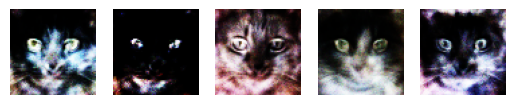

In [34]:
model = WGAN_GP()
model.Training()
model.save_model()